<a href="https://colab.research.google.com/github/Deepakkumar5570/Research_work_Projects/blob/main/Sugar_segmented_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
                  ┌────────────────────────┐
                  │  DATASET (5 CLASSES)   │
                  │ Healthy, Mosaic, etc   │
                  └───────────┬────────────┘
                              │
                              ▼
               ┌────────────────────────────┐
               │ STRATIFIED SPLIT (64/16/20)│
               │ Train / Val / Test         │
               └───────────┬────────────────┘
                           │
        ┌──────────────────┼─────────────────────┐
        │                  │                     │
        ▼                  ▼                     ▼
┌─────────────────┐ ┌─────────────────┐  ┌─────────────────┐
│ CREATE OvR DATA │ │ FOR EACH CLASS  │  │ BINARY LABELING  │
│ BinaryOvRDataset│ │ target=1, rest=0│  │ 1 vs Rest        │
└────────┬────────┘ └─────────────────┘  └────────┬────────┘
         │                                         │
         ▼                                         ▼
   ┌───────────────┐                    ┌────────────────────┐
   │  LOAD BACKBONE│  (5 Backbones)     │  TRAIN BINARY MODEL│
   │ ResNet18..152 │──────────────────▶ │ BCE Loss + Adam    │
   └───────┬──────┘                    │ Early Stopping      │
           │                            └─────────┬──────────┘
           ▼                                      │
   ┌──────────────────────┐                      ▼
   │ FINE-TUNE LAYER3/4/FC│            ┌────────────────────────┐
   │ Freeze all others     │            │ SAVE BEST WEIGHTS     │
   └───────────┬──────────┘            │ /content/ovr_weights   │
               │                       └───────────┬────────────┘
               ▼                                   │
    (Repeat for all 5 classes)                     ▼
                 ┌───────────────────────────────────────┐
                 │  5 TRAINED OvR MODELS READY            │
                 └───────────┬───────────────────────────┘
                             │
                             ▼
               ┌───────────────────────────────┐
               │ RUN ALL 5 MODELS ON TEST SET  │
               │ Collect probabilities matrix   │
               │ prob_matrix [N x 5]            │
               └───────────┬────────────────────┘
                           │
                           ▼
               ┌───────────────────────────────┐
               │ LATE FUSION (Normalize Rows)   │
               │ prob_norm = prob / row_sum     │
               │ final = argmax(prob_norm)      │
               └───────────┬────────────────────┘
                           │
                           ▼
          ┌─────────────────────────────────────────┐
          │ METRICS: Classification Report          │
          │ Confusion Matrix, ROC Curves (5× AUC)   │
          └─────────────────────────────────────────┘


In [2]:
import zipfile
import os

zip_path = "/content/sugarcaneDataset.zip"
extract_path = "/content/sugarcaneDataset"

# Create folder (if not exists)
os.makedirs(extract_path, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped successfully!")
print("📁 Extracted to:", extract_path)


✅ Dataset unzipped successfully!
📁 Extracted to: /content/sugarcaneDataset


In [3]:
import os

DATASET_DIR = "/content/sugarcaneDataset"

print("📁 Subfolders inside:", DATASET_DIR)
print("--------------------------------")

for item in os.listdir(DATASET_DIR):
    path = os.path.join(DATASET_DIR, item)
    if os.path.isdir(path):
        print("📂", item)


📁 Subfolders inside: /content/sugarcaneDataset
--------------------------------
📂 Rust
📂 RedRot
📂 Yellow
📂 Mosaic
📂 Healthy


In [4]:
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation

# ======================================================
# 1️⃣ Configuration
# ======================================================
DATASET_DIR = "/content/sugarcaneDataset"     # Input dataset (5 folders)
MODEL_PATH = "/content/segformer_model.pth"   # Your trained segmentation model
OUTPUT_DIR = "/content/segmented_output"      # Where segmented masks will be saved
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Two classes → Background(0) & Disease(1)
CLASS_NAMES = ["Background", "Disease"]
NUM_CLASSES = len(CLASS_NAMES)

print(f"Using device: {DEVICE}")
print(f"Model path: {MODEL_PATH}")

# Create output folder
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Output folder ready: {OUTPUT_DIR}")

# ======================================================
# 2️⃣ Load Model Architecture + Weights
# ======================================================
id2label = {i: name for i, name in enumerate(CLASS_NAMES)}
label2id = {name: i for i, name in enumerate(CLASS_NAMES)}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Load weights (ignore classifier mismatch)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
state_dict = {k: v for k, v in state_dict.items() if "decode_head.classifier" not in k}

model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()

print("✅ Model loaded successfully!")

# ======================================================
# 3️⃣ Image Pre-processing
# ======================================================
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======================================================
# 4️⃣ Segmentation Function (Disease=White, Background=Black)
# ======================================================
def segment_image(image_path, save_mask_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(pixel_values=input_tensor)
        logits = outputs.logits
        upsampled = F.interpolate(
            logits, size=image.size[::-1], mode='bilinear', align_corners=False
        )
        pred_mask = torch.argmax(upsampled, dim=1).squeeze().cpu().numpy().astype(np.uint8)

    # Convert → Disease=White (255), Background=Black (0)
    mask = (pred_mask * 255).astype(np.uint8)
    Image.fromarray(mask).save(save_mask_path)

# ======================================================
# 5️⃣ Segment Entire Dataset Folder-Wise
# ======================================================
for folder in sorted(os.listdir(DATASET_DIR)):
    folder_path = os.path.join(DATASET_DIR, folder)

    if not os.path.isdir(folder_path):
        continue

    print(f"\n🚀 Processing folder: {folder}")

    # Create output subfolder
    output_mask_folder = os.path.join(OUTPUT_DIR, f"{folder}_masks")
    os.makedirs(output_mask_folder, exist_ok=True)

    # List images
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in tqdm(image_files, desc=f"Segmenting {folder}"):
        input_path = os.path.join(folder_path, img_file)
        output_path = os.path.join(output_mask_folder,
                                   os.path.splitext(img_file)[0] + "_mask.png")

        segment_image(input_path, output_path)

    print(f"✅ Saved masks in: {output_mask_folder}")

print("\n🎉 All folders segmented successfully!")


Using device: cuda
Model path: /content/segformer_model.pth
📁 Output folder ready: /content/segmented_output


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!

🚀 Processing folder: Healthy


Segmenting Healthy: 100%|██████████| 522/522 [00:25<00:00, 20.85it/s]


✅ Saved masks in: /content/segmented_output/Healthy_masks

🚀 Processing folder: Mosaic


Segmenting Mosaic: 100%|██████████| 462/462 [00:32<00:00, 14.36it/s]


✅ Saved masks in: /content/segmented_output/Mosaic_masks

🚀 Processing folder: RedRot


Segmenting RedRot: 100%|██████████| 518/518 [00:24<00:00, 21.10it/s]


✅ Saved masks in: /content/segmented_output/RedRot_masks

🚀 Processing folder: Rust


Segmenting Rust: 100%|██████████| 514/514 [00:31<00:00, 16.31it/s]


✅ Saved masks in: /content/segmented_output/Rust_masks

🚀 Processing folder: Yellow


Segmenting Yellow: 100%|██████████| 505/505 [00:23<00:00, 21.57it/s]

✅ Saved masks in: /content/segmented_output/Yellow_masks

🎉 All folders segmented successfully!


In [5]:
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation

# ======================================================
# 1️⃣ Configuration
# ======================================================
DATASET_DIR = "/content/sugarcaneDataset"
MODEL_PATH = "/content/segformer_model.pth"
OUTPUT_DIR = "/content/segmented_output_overlay"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Two-class segmentation → Background(0), Disease(1)
CLASS_NAMES = ["Background", "Disease"]
NUM_CLASSES = len(CLASS_NAMES)

print(f"Using device: {DEVICE}")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Output overlay folder created: {OUTPUT_DIR}")

# ======================================================
# 2️⃣ Load Model
# ======================================================
id2label = {i: name for i, name in enumerate(CLASS_NAMES)}
label2id = {name: i for i, name in enumerate(CLASS_NAMES)}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
state_dict = {k: v for k, v in state_dict.items() if "decode_head.classifier" not in k}

model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()
print("✅ Model loaded successfully!")

# ======================================================
# 3️⃣ Preprocessing
# ======================================================
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ======================================================
# 4️⃣ Overlay Function (Disease = Red)
# ======================================================
def create_overlay(original, mask):
    original = original.convert("RGB")
    mask = mask.resize(original.size)

    mask_arr = np.array(mask)
    mask_binary = (mask_arr > 127).astype(np.uint8)

    overlay = original.copy()
    overlay_np = np.array(overlay)

    # Red overlay color
    red_layer = np.zeros_like(overlay_np)
    red_layer[:, :, 0] = 255  # Red channel = 255

    alpha = 0.5  # transparency

    overlay_np = np.where(mask_binary[:, :, None] == 1,
                          (overlay_np * (1 - alpha) + red_layer * alpha).astype(np.uint8),
                          overlay_np)

    return Image.fromarray(overlay_np)

# ======================================================
# 5️⃣ Segmentation + Overlay
# ======================================================
def segment_and_overlay(image_path, save_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(pixel_values=input_tensor)
        logits = outputs.logits
        upsampled = F.interpolate(logits, size=image.size[::-1],
                                  mode="bilinear", align_corners=False)

    pred_mask = torch.argmax(upsampled, dim=1).cpu().numpy().squeeze().astype(np.uint8)

    mask_img = Image.fromarray((pred_mask * 255).astype(np.uint8))

    overlay = create_overlay(image, mask_img)
    overlay.save(save_path)

# ======================================================
# 6️⃣ Process Dataset Folder-Wise
# ======================================================
for folder in sorted(os.listdir(DATASET_DIR)):
    folder_path = os.path.join(DATASET_DIR, folder)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n🚀 Processing: {folder}")

    output_overlay_folder = os.path.join(OUTPUT_DIR, f"{folder}_overlay")
    os.makedirs(output_overlay_folder, exist_ok=True)

    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in tqdm(image_files, desc=f"Overlaying {folder}"):
        img_path = os.path.join(folder_path, img_file)
        save_path = os.path.join(output_overlay_folder, img_file.replace(".jpg", "_overlay.jpg")
                                                               .replace(".png", "_overlay.png"))

        segment_and_overlay(img_path, save_path)

    print(f"✅ Saved overlays in: {output_overlay_folder}")

print("\n🎉 All overlay masks generated successfully!")


Using device: cuda
📁 Output overlay folder created: /content/segmented_output_overlay


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!

🚀 Processing: Healthy


Overlaying Healthy: 100%|██████████| 522/522 [00:31<00:00, 16.47it/s]


✅ Saved overlays in: /content/segmented_output_overlay/Healthy_overlay

🚀 Processing: Mosaic


Overlaying Mosaic: 100%|██████████| 462/462 [00:30<00:00, 15.02it/s]


✅ Saved overlays in: /content/segmented_output_overlay/Mosaic_overlay

🚀 Processing: RedRot


Overlaying RedRot: 100%|██████████| 518/518 [00:31<00:00, 16.34it/s]


✅ Saved overlays in: /content/segmented_output_overlay/RedRot_overlay

🚀 Processing: Rust


Overlaying Rust: 100%|██████████| 514/514 [00:39<00:00, 12.92it/s]


✅ Saved overlays in: /content/segmented_output_overlay/Rust_overlay

🚀 Processing: Yellow


Overlaying Yellow: 100%|██████████| 505/505 [00:29<00:00, 16.93it/s]

✅ Saved overlays in: /content/segmented_output_overlay/Yellow_overlay

🎉 All overlay masks generated successfully!


In [25]:
# Cell 1: Imports & seed
import os, copy, time, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print("Imports done. Device avail:", torch.cuda.is_available())


Imports done. Device avail: True


In [26]:
# Cell 2: Paths & general config
ROOT_ORIG = "/content/sugarcaneDataset"        # your original dataset root (as you already have)
ROOT_MASKS = "/content/segmented_output"       # your masks root (produced earlier by segmentation code)
# We'll create two dataset roots (original-preserved and segmented-crops)
DATASET_ORIG_OUT = "/content/dataset_original"     # will copy original images into this organized structure
DATASET_SEG_OUT  = "/content/dataset_segmented"    # will save cropped images based on masks into this structure

# classes (must match your folder names)
class_names = ['Rust','RedRot','Yellow','Mosaic','Healthy']  # order must match original folders
# training params (keep same as your provided code)
batch_size = 32
epochs_max = 30
init_lr = 1e-4
patience = 5
min_delta = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [27]:
# Cell 3: create dataset_original by copying original images into class-wise folders
import shutil

def prepare_original_dataset(src_root, dest_root, classes):
    os.makedirs(dest_root, exist_ok=True)
    for cls in classes:
        src_cls = os.path.join(src_root, cls)
        dest_cls = os.path.join(dest_root, cls)
        os.makedirs(dest_cls, exist_ok=True)
        if not os.path.isdir(src_cls):
            print(f"Warning: source class folder missing: {src_cls}")
            continue
        # copy image files (not overwrite if exist)
        for fname in os.listdir(src_cls):
            if not fname.lower().endswith(('.png','.jpg','.jpeg')):
                continue
            src_p = os.path.join(src_cls, fname)
            dest_p = os.path.join(dest_cls, fname)
            if not os.path.exists(dest_p):
                shutil.copy2(src_p, dest_p)
    print("Original dataset organized at:", dest_root)

prepare_original_dataset(ROOT_ORIG, DATASET_ORIG_OUT, class_names)


Original dataset organized at: /content/dataset_original


In [28]:
# Cell 4: prepare dataset_segmented using masks to crop diseased region
import cv2

def crop_by_mask_and_save(orig_root, masks_root, dest_root, classes, mask_suffix="_mask.png"):
    os.makedirs(dest_root, exist_ok=True)
    for cls in classes:
        src_cls = os.path.join(orig_root, cls)
        mask_cls = os.path.join(masks_root, f"{cls}_masks")   # earlier code created <class>_masks folders
        dest_cls = os.path.join(dest_root, cls)
        os.makedirs(dest_cls, exist_ok=True)
        if not os.path.isdir(src_cls):
            print(f"Warning: original class folder missing: {src_cls}")
            continue

        files = [f for f in os.listdir(src_cls) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        for fname in files:
            orig_p = os.path.join(src_cls, fname)
            # mask file expected name: <stem>_mask.png
            stem = os.path.splitext(fname)[0]
            mask_fname = stem + mask_suffix
            mask_p = os.path.join(mask_cls, mask_fname)
            try:
                img = cv2.imread(orig_p)  # BGR
                if img is None:
                    print("Failed to read image:", orig_p); continue
                h, w = img.shape[:2]
                if os.path.exists(mask_p):
                    m = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
                    if m is None:
                        # fallback: save resized full image
                        crop = cv2.resize(img, (224,224))
                    else:
                        # threshold mask -> binary (disease white)
                        _, mb = cv2.threshold(m, 127, 255, cv2.THRESH_BINARY)
                        # find contours to get bounding box
                        coords = cv2.findNonZero(mb)
                        if coords is None:
                            # no diseased region: use resized original
                            crop = cv2.resize(img, (224,224))
                        else:
                            x,y,w_box,h_box = cv2.boundingRect(coords)
                            # expand bbox slightly (10%)
                            pad_x = int(0.1 * w_box); pad_y = int(0.1 * h_box)
                            x1 = max(0, x - pad_x); y1 = max(0, y - pad_y)
                            x2 = min(w, x + w_box + pad_x); y2 = min(h, y + h_box + pad_y)
                            crop = img[y1:y2, x1:x2]
                            if crop.size == 0:
                                crop = cv2.resize(img, (224,224))
                            else:
                                crop = cv2.resize(crop, (224,224))
                else:
                    # mask missing: use resized original
                    crop = cv2.resize(img, (224,224))
                # save as jpg
                save_p = os.path.join(dest_cls, stem + ".jpg")
                cv2.imwrite(save_p, crop)
            except Exception as e:
                print("Error processing", orig_p, e)
    print("Segmented-derived dataset created at:", dest_root)

crop_by_mask_and_save(DATASET_ORIG_OUT, ROOT_MASKS, DATASET_SEG_OUT, class_names)


Segmented-derived dataset created at: /content/dataset_segmented


In [29]:
# Cell 5: quick verify counts
def print_counts(root, classes):
    print("Dataset:", root)
    for c in classes:
        p = os.path.join(root, c)
        n = len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))]) if os.path.isdir(p) else 0
        print(f"  {c}: {n}")
print_counts(DATASET_ORIG_OUT, class_names)
print_counts(DATASET_SEG_OUT, class_names)


Dataset: /content/dataset_original
  Rust: 514
  RedRot: 518
  Yellow: 505
  Mosaic: 462
  Healthy: 522
Dataset: /content/dataset_segmented
  Rust: 514
  RedRot: 518
  Yellow: 505
  Mosaic: 462
  Healthy: 522


In [30]:
# Cell 6: Training pipeline functions (OvR), reuse your exact architecture
from torchvision import datasets

def run_ovr_pipeline(data_dir, weights_dir="/content/ovr_weights", run_name="run"):
    os.makedirs(weights_dir, exist_ok=True)
    print(f"\n=== Starting OvR pipeline for dataset: {data_dir} ===")

    # Transforms (using same transforms from your original code)
    train_tfms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

    base_dataset = datasets.ImageFolder(root=data_dir, transform=eval_tfms)
    if base_dataset.classes != class_names:
        print("Warning: dataset classes differ. Found:", base_dataset.classes, "Expected:", class_names)
    targets = np.array(base_dataset.targets)
    indices = np.arange(len(base_dataset))

    # stratified splits
    trainval_idx, test_idx = train_test_split(indices, test_size=0.20, stratify=targets, random_state=42)
    train_targets = targets[trainval_idx]
    train_idx, val_idx = train_test_split(trainval_idx, test_size=0.20, stratify=train_targets, random_state=42)

    # copy dataset objects and assign transforms
    train_dataset = copy.copy(base_dataset); train_dataset.transform = train_tfms
    val_dataset = copy.copy(base_dataset); val_dataset.transform = eval_tfms
    test_dataset = copy.copy(base_dataset); test_dataset.transform = eval_tfms

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)
    test_subset = Subset(test_dataset, test_idx)

    # OvR Dataset wrapper (same as yours)
    class BinaryOvRDataset(Dataset):
        def __init__(self, subset, target_class_idx):
            self.subset = subset
            self.target_class_idx = target_class_idx
        def __len__(self):
            return len(self.subset)
        def __getitem__(self, i):
            img, orig_label = self.subset[i]
            y = 1 if orig_label == self.target_class_idx else 0
            return img, torch.tensor(y, dtype=torch.long)

    def make_loaders_for_class(target_class_idx, batch_size=batch_size, num_workers=2):
        train_ds_bin = BinaryOvRDataset(train_subset, target_class_idx)
        val_ds_bin   = BinaryOvRDataset(val_subset, target_class_idx)
        test_ds_bin  = BinaryOvRDataset(test_subset, target_class_idx)
        train_loader = DataLoader(train_ds_bin, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
        val_loader   = DataLoader(val_ds_bin,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        test_loader  = DataLoader(test_ds_bin,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        return train_loader, val_loader, test_loader

    # backbone builder (same)
    def build_backbone(backbone_name: str) -> nn.Module:
        if backbone_name == 'resnet18':
            m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        elif backbone_name == 'resnet34':
            m = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        elif backbone_name == 'resnet50':
            m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        elif backbone_name == 'resnet101':
            m = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        elif backbone_name == 'resnet152':
            m = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        else:
            raise ValueError(f"Unknown backbone {backbone_name}")

        # Freeze all except layer3, layer4, fc
        for name, p in m.named_parameters():
            if "layer3" in name or "layer4" in name or "fc" in name:
                p.requires_grad = True
            else:
                p.requires_grad = False

        in_features = m.fc.in_features
        m.fc = nn.Linear(in_features, 1)  # binary logit
        return m.to(device)

    # train function (same)
    def train_binary_model(model, train_loader, val_loader, epochs=epochs_max, lr=init_lr,
                           patience=patience, min_delta=min_delta):
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        best_val_loss = float('inf')
        best_weights = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0

        for epoch in range(1, epochs + 1):
            model.train()
            running_loss = 0.0
            for x, y in train_loader:
                x = x.to(device)
                y = y.float().unsqueeze(1).to(device)
                optimizer.zero_grad()
                logits = model(x)
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # validate
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    y = y.float().unsqueeze(1).to(device)
                    logits = model(x)
                    loss = criterion(logits, y)
                    val_loss += loss.item()
            val_loss /= max(1, len(val_loader))

            print(f"Epoch {epoch:02d}/{epochs} | TrainLoss: {running_loss/max(1,len(train_loader)):.4f} | ValLoss: {val_loss:.4f}")

            if best_val_loss - val_loss > min_delta:
                best_val_loss = val_loss
                best_weights = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"⏹ Early stopping at epoch {epoch}")
                    break

        model.load_state_dict(best_weights)
        return model, best_val_loss

    # Training OvR for each class
    models_ovr = {}
    for c_idx, c_name in enumerate(class_names):
        print(f"\n==============================")
        print(f"Training OvR for: {c_name}  | Backbone: {class_to_backbone[c_name]}")
        print(f"==============================")
        train_loader, val_loader, test_loader = make_loaders_for_class(c_idx, batch_size=batch_size)
        model_bin = build_backbone(class_to_backbone[c_name])
        model_bin, best_loss = train_binary_model(model_bin, train_loader, val_loader,
                                                 epochs=epochs_max, lr=init_lr,
                                                 patience=patience, min_delta=min_delta)
        save_path = os.path.join(weights_dir, f"{class_to_backbone[c_name]}_OvR_{c_name}.pth")
        torch.save(model_bin.state_dict(), save_path)
        print(f"✅ Saved best weights -> {save_path} | Best ValLoss: {best_loss:.4f}")
        model_bin.eval()
        models_ovr[c_name] = model_bin

    # Late fusion on common test set
    plain_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Collect probabilities for each class model over the same test samples
    prob_matrix = []  # will be [N, 5]
    with torch.no_grad():
        for c_name in class_names:
            model_c = models_ovr[c_name]
            probs_c = []
            for x, _ in plain_test_loader:
                x = x.to(device)
                logits = model_c(x)
                p = torch.sigmoid(logits).squeeze(1)
                probs_c.append(p.cpu().numpy())
            probs_c = np.concatenate(probs_c)
            prob_matrix.append(probs_c)

    prob_matrix = np.vstack(prob_matrix).T

    # True multiclass labels
    y_true_multi = []
    for _, y in plain_test_loader:
        y_true_multi.append(y.numpy())
    y_true_multi = np.concatenate(y_true_multi)

    # Normalize row-wise then argmax
    row_sums = prob_matrix.sum(axis=1, keepdims=True) + 1e-8
    prob_norm = prob_matrix / row_sums
    y_pred_final = np.argmax(prob_norm, axis=1)

    print("\n=== LATE FUSION — Classification Report ===")
    print(classification_report(y_true_multi, y_pred_final, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true_multi, y_pred_final)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix (Late Fusion) - {run_name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ROC Curves
    y_true_bin = label_binarize(y_true_multi, classes=list(range(len(class_names))))
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_matrix[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves (Late Fusion) - {run_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return models_ovr, prob_matrix, y_true_multi, y_pred_final



=== Starting OvR pipeline for dataset: /content/dataset_original ===

Training OvR for: Rust  | Backbone: resnet101
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:01<00:00, 128MB/s]


Epoch 01/30 | TrainLoss: 0.3266 | ValLoss: 0.1404
Epoch 02/30 | TrainLoss: 0.0928 | ValLoss: 0.0302
Epoch 03/30 | TrainLoss: 0.0564 | ValLoss: 0.0371
Epoch 04/30 | TrainLoss: 0.0465 | ValLoss: 0.0222
Epoch 05/30 | TrainLoss: 0.0196 | ValLoss: 0.0528
Epoch 06/30 | TrainLoss: 0.0292 | ValLoss: 0.0248
Epoch 07/30 | TrainLoss: 0.0263 | ValLoss: 0.0136
Epoch 08/30 | TrainLoss: 0.0204 | ValLoss: 0.0254
Epoch 09/30 | TrainLoss: 0.0377 | ValLoss: 0.0279
Epoch 10/30 | TrainLoss: 0.0142 | ValLoss: 0.0191
Epoch 11/30 | TrainLoss: 0.0161 | ValLoss: 0.0225
Epoch 12/30 | TrainLoss: 0.0090 | ValLoss: 0.0310
⏹ Early stopping at epoch 12
✅ Saved best weights -> /content/ovr_weights_orig/resnet101_OvR_Rust.pth | Best ValLoss: 0.0136

Training OvR for: RedRot  | Backbone: resnet50
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:04<00:00, 22.1MB/s]


Epoch 01/30 | TrainLoss: 0.3867 | ValLoss: 0.1832
Epoch 02/30 | TrainLoss: 0.1445 | ValLoss: 0.1238
Epoch 03/30 | TrainLoss: 0.0910 | ValLoss: 0.1326
Epoch 04/30 | TrainLoss: 0.0638 | ValLoss: 0.1259
Epoch 05/30 | TrainLoss: 0.0530 | ValLoss: 0.0816
Epoch 06/30 | TrainLoss: 0.0501 | ValLoss: 0.0729
Epoch 07/30 | TrainLoss: 0.0332 | ValLoss: 0.0899
Epoch 08/30 | TrainLoss: 0.0295 | ValLoss: 0.0721
Epoch 09/30 | TrainLoss: 0.0254 | ValLoss: 0.0540
Epoch 10/30 | TrainLoss: 0.0170 | ValLoss: 0.0736
Epoch 11/30 | TrainLoss: 0.0136 | ValLoss: 0.0673
Epoch 12/30 | TrainLoss: 0.0325 | ValLoss: 0.0689
Epoch 13/30 | TrainLoss: 0.0256 | ValLoss: 0.0467
Epoch 14/30 | TrainLoss: 0.0207 | ValLoss: 0.0423
Epoch 15/30 | TrainLoss: 0.0118 | ValLoss: 0.0524
Epoch 16/30 | TrainLoss: 0.0117 | ValLoss: 0.0497
Epoch 17/30 | TrainLoss: 0.0100 | ValLoss: 0.0338
Epoch 18/30 | TrainLoss: 0.0213 | ValLoss: 0.0652
Epoch 19/30 | TrainLoss: 0.0147 | ValLoss: 0.0694
Epoch 20/30 | TrainLoss: 0.0090 | ValLoss: 0.0603


100%|██████████| 230M/230M [00:02<00:00, 105MB/s]


Epoch 01/30 | TrainLoss: 0.3380 | ValLoss: 0.1261
Epoch 02/30 | TrainLoss: 0.0823 | ValLoss: 0.0763
Epoch 03/30 | TrainLoss: 0.0508 | ValLoss: 0.0594
Epoch 04/30 | TrainLoss: 0.0270 | ValLoss: 0.0740
Epoch 05/30 | TrainLoss: 0.0262 | ValLoss: 0.0556
Epoch 06/30 | TrainLoss: 0.0267 | ValLoss: 0.0386
Epoch 07/30 | TrainLoss: 0.0167 | ValLoss: 0.0319
Epoch 08/30 | TrainLoss: 0.0193 | ValLoss: 0.0409
Epoch 09/30 | TrainLoss: 0.0199 | ValLoss: 0.0352
Epoch 10/30 | TrainLoss: 0.0090 | ValLoss: 0.0241
Epoch 11/30 | TrainLoss: 0.0203 | ValLoss: 0.0420
Epoch 12/30 | TrainLoss: 0.0088 | ValLoss: 0.0366
Epoch 13/30 | TrainLoss: 0.0082 | ValLoss: 0.0402
Epoch 14/30 | TrainLoss: 0.0062 | ValLoss: 0.0385
Epoch 15/30 | TrainLoss: 0.0107 | ValLoss: 0.0591
⏹ Early stopping at epoch 15
✅ Saved best weights -> /content/ovr_weights_orig/resnet152_OvR_Yellow.pth | Best ValLoss: 0.0241

Training OvR for: Mosaic  | Backbone: resnet34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to

100%|██████████| 83.3M/83.3M [00:05<00:00, 17.0MB/s]


Epoch 01/30 | TrainLoss: 0.3594 | ValLoss: 0.2295
Epoch 02/30 | TrainLoss: 0.1015 | ValLoss: 0.1012
Epoch 03/30 | TrainLoss: 0.0870 | ValLoss: 0.0470
Epoch 04/30 | TrainLoss: 0.1302 | ValLoss: 0.1029
Epoch 05/30 | TrainLoss: 0.0380 | ValLoss: 0.0383
Epoch 06/30 | TrainLoss: 0.0282 | ValLoss: 0.0501
Epoch 07/30 | TrainLoss: 0.0270 | ValLoss: 0.0605
Epoch 08/30 | TrainLoss: 0.0350 | ValLoss: 0.0426
Epoch 09/30 | TrainLoss: 0.0195 | ValLoss: 0.0278
Epoch 10/30 | TrainLoss: 0.0520 | ValLoss: 0.1017
Epoch 11/30 | TrainLoss: 0.0313 | ValLoss: 0.0483
Epoch 12/30 | TrainLoss: 0.0298 | ValLoss: 0.0288
Epoch 13/30 | TrainLoss: 0.0123 | ValLoss: 0.0305
Epoch 14/30 | TrainLoss: 0.0289 | ValLoss: 0.0583
⏹ Early stopping at epoch 14
✅ Saved best weights -> /content/ovr_weights_orig/resnet34_OvR_Mosaic.pth | Best ValLoss: 0.0278

Training OvR for: Healthy  | Backbone: resnet18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f3707

100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Epoch 01/30 | TrainLoss: 0.3042 | ValLoss: 0.1767
Epoch 02/30 | TrainLoss: 0.1029 | ValLoss: 0.0975
Epoch 03/30 | TrainLoss: 0.0870 | ValLoss: 0.0948
Epoch 04/30 | TrainLoss: 0.1093 | ValLoss: 0.0581
Epoch 05/30 | TrainLoss: 0.0540 | ValLoss: 0.1147
Epoch 06/30 | TrainLoss: 0.0589 | ValLoss: 0.0395
Epoch 07/30 | TrainLoss: 0.0571 | ValLoss: 0.0519
Epoch 08/30 | TrainLoss: 0.0530 | ValLoss: 0.0620
Epoch 09/30 | TrainLoss: 0.0470 | ValLoss: 0.0696
Epoch 10/30 | TrainLoss: 0.0328 | ValLoss: 0.0601
Epoch 11/30 | TrainLoss: 0.0214 | ValLoss: 0.0718
⏹ Early stopping at epoch 11
✅ Saved best weights -> /content/ovr_weights_orig/resnet18_OvR_Healthy.pth | Best ValLoss: 0.0395

=== LATE FUSION — Classification Report ===
              precision    recall  f1-score   support

        Rust     0.9904    0.9810    0.9856       105
      RedRot     0.9674    0.9674    0.9674        92
      Yellow     0.9905    1.0000    0.9952       104
      Mosaic     0.9533    0.9903    0.9714       103
     He

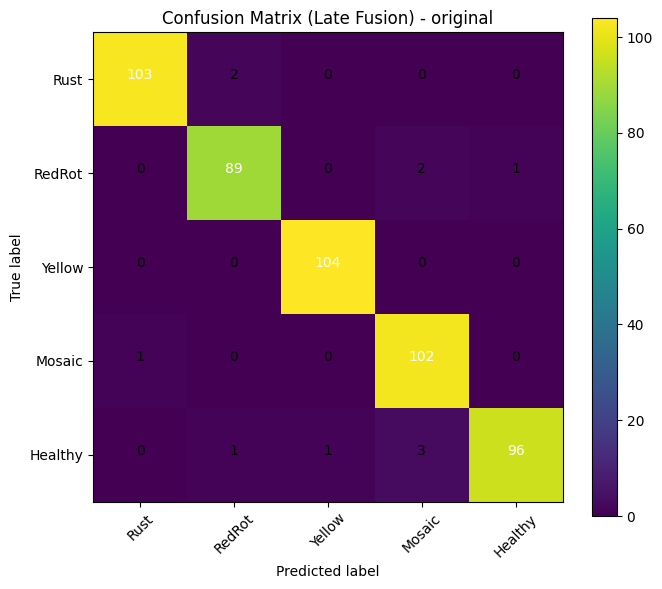

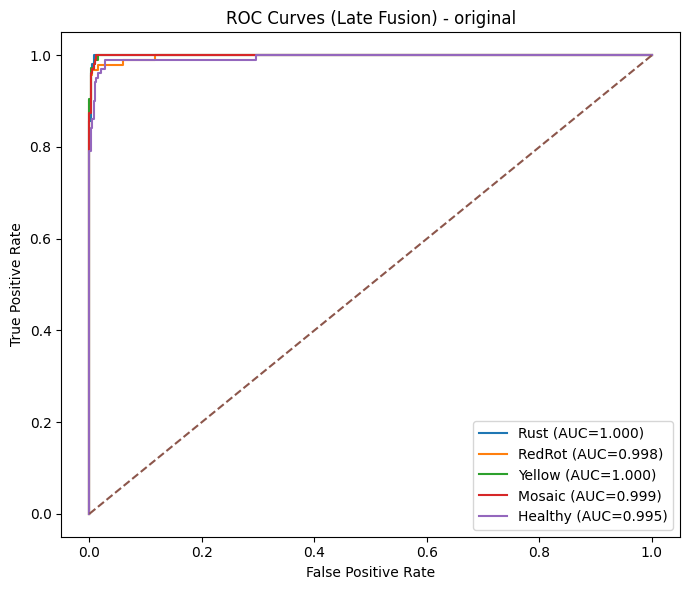

In [31]:
# Cell 7: Train / evaluate on original dataset
weights_dir_orig = "/content/ovr_weights_orig"
models_orig, prob_mat_orig, y_true_orig, y_pred_orig = run_ovr_pipeline(DATASET_ORIG_OUT, weights_dir=weights_dir_orig, run_name="original")



=== Starting OvR pipeline for dataset: /content/dataset_segmented ===

Training OvR for: Rust  | Backbone: resnet101
Epoch 01/30 | TrainLoss: 0.3275 | ValLoss: 0.1315
Epoch 02/30 | TrainLoss: 0.1035 | ValLoss: 0.0925
Epoch 03/30 | TrainLoss: 0.0754 | ValLoss: 0.0641
Epoch 04/30 | TrainLoss: 0.0503 | ValLoss: 0.0620
Epoch 05/30 | TrainLoss: 0.0349 | ValLoss: 0.0607
Epoch 06/30 | TrainLoss: 0.0332 | ValLoss: 0.0375
Epoch 07/30 | TrainLoss: 0.0261 | ValLoss: 0.0430
Epoch 08/30 | TrainLoss: 0.0289 | ValLoss: 0.0455
Epoch 09/30 | TrainLoss: 0.0187 | ValLoss: 0.0322
Epoch 10/30 | TrainLoss: 0.0203 | ValLoss: 0.0262
Epoch 11/30 | TrainLoss: 0.0144 | ValLoss: 0.0272
Epoch 12/30 | TrainLoss: 0.0232 | ValLoss: 0.0118
Epoch 13/30 | TrainLoss: 0.0176 | ValLoss: 0.0285
Epoch 14/30 | TrainLoss: 0.0069 | ValLoss: 0.0387
Epoch 15/30 | TrainLoss: 0.0162 | ValLoss: 0.0454
Epoch 16/30 | TrainLoss: 0.0054 | ValLoss: 0.0320
Epoch 17/30 | TrainLoss: 0.0145 | ValLoss: 0.0629
⏹ Early stopping at epoch 17
✅ S

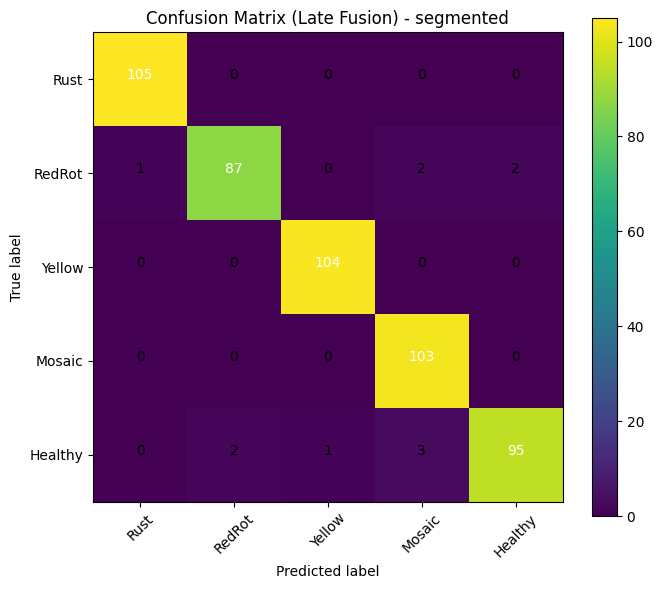

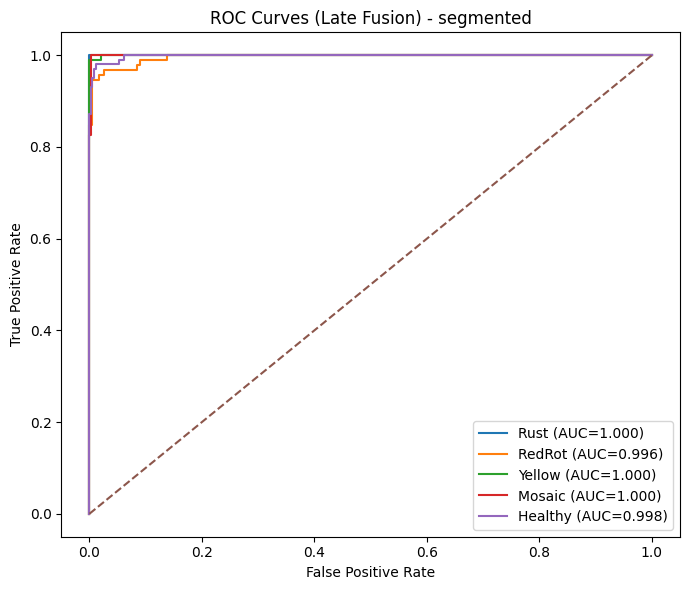

In [32]:
# Cell 8: Train / evaluate on segmented-derived dataset
weights_dir_seg = "/content/ovr_weights_segmented"
models_seg, prob_mat_seg, y_true_seg, y_pred_seg = run_ovr_pipeline(DATASET_SEG_OUT, weights_dir=weights_dir_seg, run_name="segmented")


In [33]:
# Cell 9: quick numeric comparison
from sklearn.metrics import accuracy_score, f1_score

print("Original: Accuracy", accuracy_score(y_true_orig, y_pred_orig), "MacroF1", f1_score(y_true_orig, y_pred_orig, average='macro'))
print("Segmented: Accuracy", accuracy_score(y_true_seg, y_pred_seg), "MacroF1", f1_score(y_true_seg, y_pred_seg, average='macro'))

# You can also compare per-class F1 quickly:
from sklearn.metrics import precision_recall_fscore_support

p_r_f_orig = precision_recall_fscore_support(y_true_orig, y_pred_orig, average=None, labels=range(len(class_names)))
p_r_f_seg  = precision_recall_fscore_support(y_true_seg, y_pred_seg, average=None, labels=range(len(class_names)))
for i, cname in enumerate(class_names):
    print(f"{cname} - Orig F1: {p_r_f_orig[2][i]:.4f} | Seg F1: {p_r_f_seg[2][i]:.4f}")


Original: Accuracy 0.9782178217821782 MacroF1 0.9778756178985013
Segmented: Accuracy 0.9782178217821782 MacroF1 0.9775402436988454
Rust - Orig F1: 0.9856 | Seg F1: 0.9953
RedRot - Orig F1: 0.9674 | Seg F1: 0.9613
Yellow - Orig F1: 0.9952 | Seg F1: 0.9952
Mosaic - Orig F1: 0.9714 | Seg F1: 0.9763
Healthy - Orig F1: 0.9697 | Seg F1: 0.9596


In [40]:
print("\n========== FINAL TEST ACCURACIES =========")
print("Original Test Accuracy:", accuracy_score(y_true_orig, y_pred_orig))
print("Segmented Test Accuracy:", accuracy_score(y_true_seg, y_pred_seg))

print("\n========== FINAL MACRO F1 =========")
print("Original Macro F1:", f1_score(y_true_orig, y_pred_orig, average='macro'))
print("Segmented Macro F1:", f1_score(y_true_seg, y_pred_seg, average='macro'))



========== FINAL TEST ACCURACIES =========
Original Test Accuracy: 0.9782178217821782
Segmented Test Accuracy: 0.9782178217821782

========== FINAL MACRO F1 =========
Original Macro F1: 0.9778756178985013
Segmented Macro F1: 0.9775402436988454


In [41]:
import shutil
from google.colab import files

# 1) segmented_output → ZIP
shutil.make_archive("/content/segmented_output", 'zip', "/content/segmented_output")
files.download("/content/segmented_output.zip")

# 2) segmented_output_overlay → ZIP
shutil.make_archive("/content/segmented_output_overlay", 'zip', "/content/segmented_output_overlay")
files.download("/content/segmented_output_overlay.zip")

# 3) segmented_prepared → ZIP
shutil.make_archive("/content/segmented_prepared", 'zip', "/content/segmented_prepared")
files.download("/content/segmented_prepared.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>